# Diffusion Models in Depth - Implementation of a diffusion model for MNIST using PyTorch

Necessary imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

from models import DiffusionModel, UNet

import numpy as np
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")           # GPU
elif torch.backends.mps.is_available():     
    device = torch.device("mps")            # Metal (for M-series Macs)
else:
    device = torch.device("cpu")            # CPU

print(f"Using device: {device}")

Using device: mps


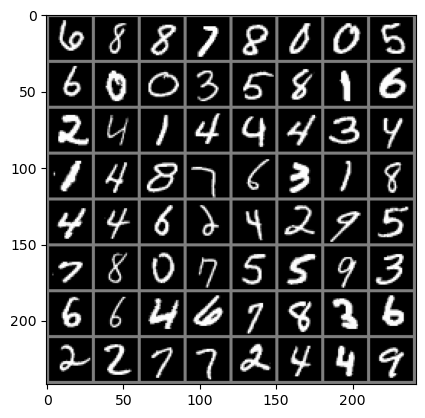

In [3]:
torch.random.manual_seed(0)
np.random.seed(0)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataset = datasets.MNIST(root="data", download=True, transform=transform)

data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

features, labels = next(iter(data_loader))
img = torchvision.utils.make_grid(features)

img = img.permute(1, 2, 0)
img = img / 2 + 0.5
plt.imshow(img)

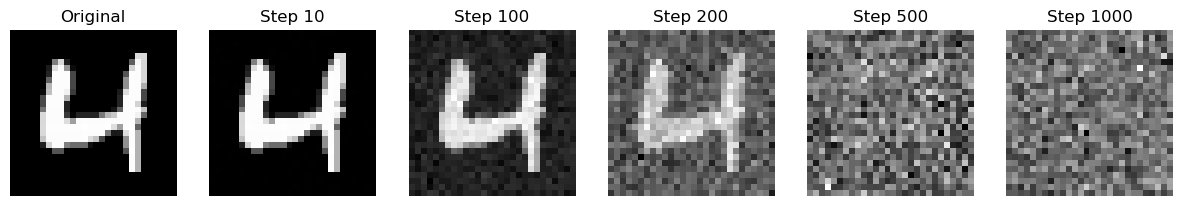

In [4]:
unet = UNet.UNet(1).to(device)
steps = torch.Tensor(1000).to(device)
ddpm = DiffusionModel.DiffusionModel(steps, unet, device)

def show_forward_process(x_0, steps: list):

    # Create a figure with subplots
    fig, ax = plt.subplots(1, len(steps) + 1, figsize=(15, 5))

    # Show the original image
    ax[0].imshow((x_0[0].permute(1, 2, 0)) / 2 + 0.5, cmap="gray")
    ax[0].axis("off")
    ax[0].set_title("Original")

    # Show the forward process
    for i, step in enumerate(steps):
        x_0 = x_0.to(device)
        x_t = ddpm.forward_process(x_0, step-1)
        x_t = x_t.cpu().detach()
        ax[i + 1].imshow((x_t[0].permute(1, 2, 0)) / 2 + 0.5, cmap="gray")
        ax[i + 1].axis("off")
        ax[i + 1].set_title(f"Step {step}")

# Pick a random image from the dataset
img = (dataset[np.random.randint(0, len(dataset))][0]).unsqueeze(0)

# Show the forward process
show_forward_process(img, [10, 100, 200, 500, 1000])


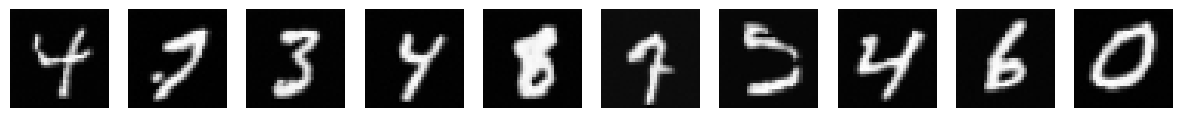

In [9]:
# Load the model
state_dict = torch.load("unet_model_state.pth", map_location=device)
unet.load_state_dict(state_dict)

denoised = ddpm.sample()

def tensor_to_images(tensor):
    batch_size = tensor.shape[0]
    images = []
    for i in range(batch_size):
        image = tensor[i].permute(1, 2, 0).cpu().detach().numpy()
        image = image / 2 + 0.5
        images.append(image)

    return images

# Show batch of denoised images
denoised_images = tensor_to_images(denoised)
fig, ax = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    ax[i].imshow(denoised_images[i], cmap="gray")
    ax[i].axis("off")


plt.axis("off")
plt.show()
